# __MRI DETECTION__

## __PREPROCESSING__

In [770]:
import pandas as pd
import numpy as np

X_train_df = pd.read_csv('X_train.csv').drop('id', axis='columns')
y_train_df = pd.read_csv('y_train.csv').drop('id', axis='columns')

X_test = pd.read_csv('X_test.csv').drop('id', axis='columns')

print(f"shape of X_train_df is : {X_train_df.shape}")
print(f"shape of y_train_df is : {y_train_df.shape}")
print(f"shape of X_test is : {X_test.shape}\n")

shape of X_train_df is : (1212, 832)
shape of y_train_df is : (1212, 1)
shape of X_test is : (776, 832)



## __*IMPUTE VALUES WITH KNN*__

In [771]:
from sklearn.impute import KNNImputer

# NOTE IMPUTING WITH KNN
missing_cols_train = X_train_df.columns[X_train_df.isna().sum() > 0]
missing_cols_test = X_test.columns[X_test.isna().sum() > 0]

print(f"Features with missing values in X_train: {len(missing_cols_train)}")
print(f"Features with missing values in X_test: {len(missing_cols_test)}\n")

imputer = KNNImputer(n_neighbors=5)
X_imp_train = pd.DataFrame(imputer.fit_transform(X_train_df), columns=X_train_df.columns)
X_imp_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

miss_tr_after = X_imp_train.columns[X_imp_train.isna().sum() > 0]
miss_test_after = X_imp_test.columns[X_imp_test.isna().sum() > 0]

print(f"Features with missing values in X_train after imputing: {len(miss_tr_after)}")
print(f"Features with missing values in X_val after imputing: {len(miss_test_after)}")

Features with missing values in X_train: 832
Features with missing values in X_test: 832

Features with missing values in X_train after imputing: 0
Features with missing values in X_val after imputing: 0


## __*REMOVE COSTANT FEATURE (0 VARIANCE)*__

Found 4 constant features: ['x104', 'x129', 'x489', 'x530']


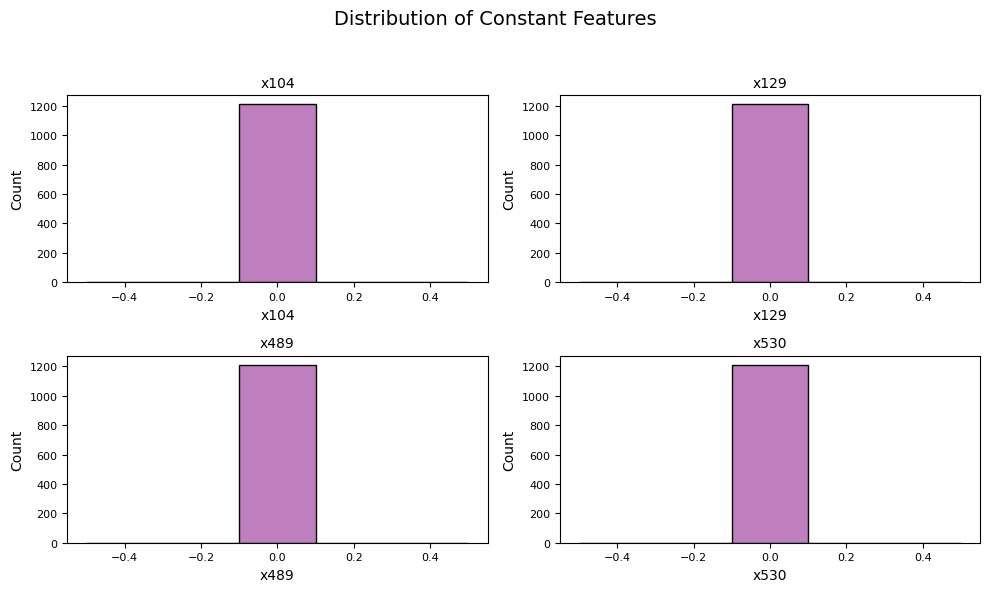


Shape after removing constant features X_impt_train: (1212, 828)
Shape after removing constant features X_imp_test: (776, 828)


In [772]:
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE:Remove zero variance features and plot them
constant_features = X_imp_train.columns[X_imp_train.nunique() <= 1]
print(f"Found {len(constant_features)} constant features: {list(constant_features)}")

num = len(constant_features)
if num > 0:
    rows = 2
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
    axes = axes.flatten()

    for i, col in enumerate(constant_features):
        ax = axes[i]
        sns.histplot(X_imp_train[col], bins=5, kde=True, ax=ax, color='purple')
        ax.set_title(col, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    for j in range(num, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Distribution of Constant Features", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("No constant features found.")

X_imp_train.drop(columns=constant_features, inplace=True)
X_imp_test.drop(columns=constant_features, inplace=True)

print(f"\nShape after removing constant features X_impt_train: {X_imp_train.shape}")
print(f"Shape after removing constant features X_imp_test: {X_imp_test.shape}")

Removed 55 outliers out of 1212 samples (4.54%)


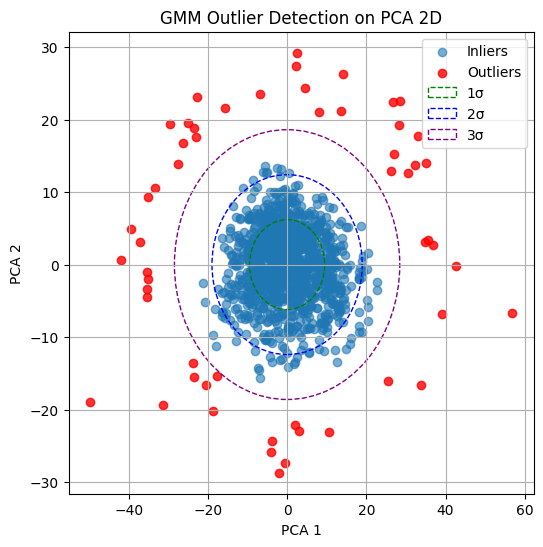

In [773]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def clean_with_gmm_pca2d(X_train, y_train, outlier_percentile=4.5):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    pca_2d = PCA(n_components=2, random_state=42)
    X_2d = pca_2d.fit_transform(X_scaled)

    gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
    gmm.fit(X_2d)
    log_likelihood = gmm.score_samples(X_2d)

    threshold = np.percentile(log_likelihood, outlier_percentile)
    mask = log_likelihood >= threshold
    n_outliers = (~mask).sum()
    print(f"Removed {n_outliers} outliers out of {len(X_scaled)} samples ({100*n_outliers/len(X_scaled):.2f}%)")

    X_train_clean = X_train[mask]
    y_train_clean = y_train[mask]

    plt.figure(figsize=(6,6))
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label='Inliers', alpha=0.6)
    plt.scatter(X_2d[~mask, 0], X_2d[~mask, 1], label='Outliers', color='red', alpha=0.8)

    def plot_gmm_ellipse(gmm, ax, n_std=2.0, facecolor='none', **kwargs):
        for mean, cov in zip(gmm.means_, gmm.covariances_):
            v, w = np.linalg.eigh(cov)
            order = v.argsort()[::-1]
            v, w = v[order], w[:, order]
            angle = np.degrees(np.arctan2(*w[:,0][::-1]))
            width, height = 2 * n_std * np.sqrt(v)
            ellip = Ellipse(xy=mean, width=width, height=height, angle=angle,
                            facecolor=facecolor, **kwargs)
            ax.add_patch(ellip)

    ax = plt.gca()
    plot_gmm_ellipse(gmm, ax, n_std=1, edgecolor='green', linestyle='--', label='1σ')
    plot_gmm_ellipse(gmm, ax, n_std=2, edgecolor='blue', linestyle='--', label='2σ')
    plot_gmm_ellipse(gmm, ax, n_std=3, edgecolor='purple', linestyle='--', label='3σ')

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('GMM Outlier Detection on PCA 2D')
    plt.legend()
    plt.grid(True)
    plt.show()

    return X_train_clean, y_train_clean, mask, pca_2d, gmm, threshold

X_imp_train, y_train_df, mask_train, pca_2d_train, gmm_train, threshold_train = clean_with_gmm_pca2d(X_imp_train,y_train_df, outlier_percentile=4.5)

## __GRAY MATTER VOLUME__

Found 5 GM-like features:
x384    619429.757943
x385    572101.117836
x414    552549.626299
x620    647452.474630
x682    564672.902569
dtype: float64
x384 min: 619429.70681733 max: 619429.80674722 mean: 619429.7579432626
x385 min: 572101.06822529 max: 572101.16796828 mean: 572101.1178355806
x414 min: 394532.60008886 max: 738228.31524698 mean: 552549.6262986633
x620 min: 647452.42329551 max: 647452.52324221 mean: 647452.4746298423
x682 min: 564672.85337097 max: 564672.95328557 mean: 564672.9025692128


/tmp/ipykernel_23436/2983552901.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


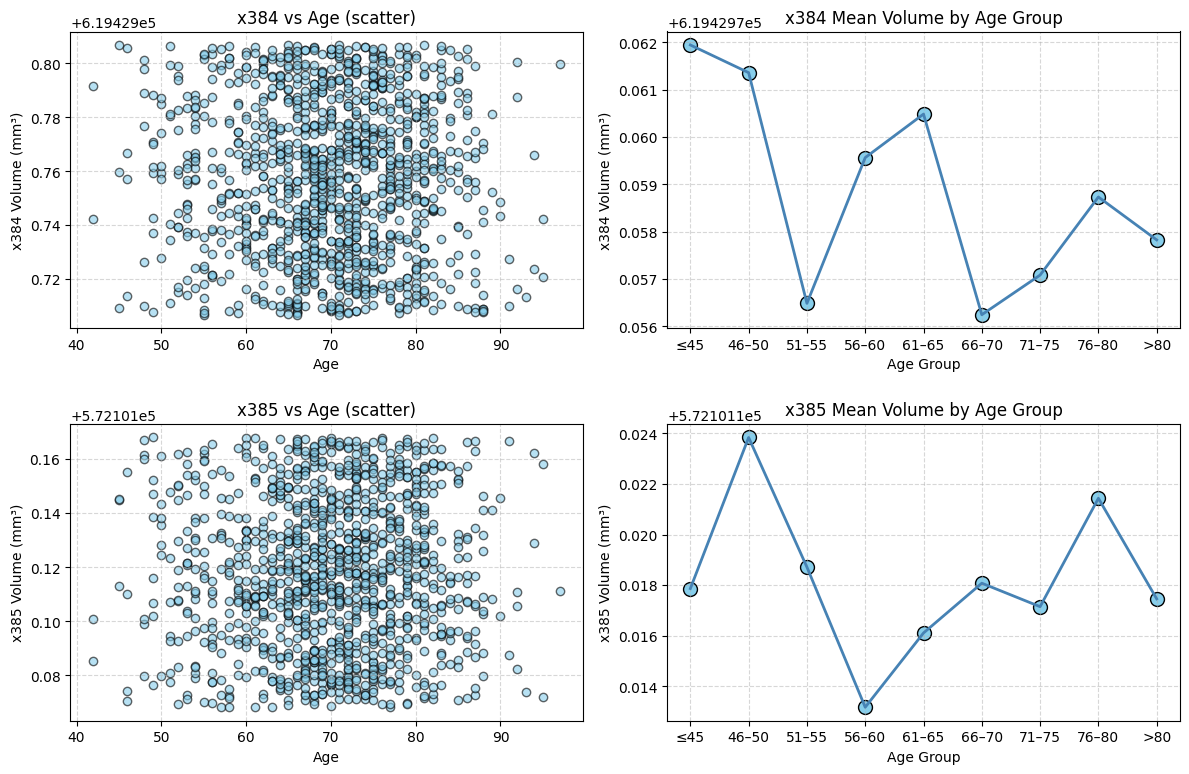

In [774]:
import matplotlib.pyplot as plt

y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

gm_min_mm3 = 540 * 1000  
gm_max_mm3 = 650 * 1000  

feature_means = X_imp_train.mean()

gm_like_features = feature_means[(feature_means >= gm_min_mm3) & (feature_means <= gm_max_mm3)]
print(f"Found {len(gm_like_features)} GM-like features:")
print(gm_like_features)

for feat in gm_like_features.index[:10]:
    print(feat,
          "min:", X_imp_train[feat].min(),
          "max:", X_imp_train[feat].max(),
          "mean:", X_imp_train[feat].mean())

top_features_gm = gm_like_features.index  

bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

top_features_gm = gm_like_features.index[:2]  

n_rows = len(top_features_gm)
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_gm):
    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.6, color='skyblue', edgecolor='k')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)

    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='skyblue', s=100, edgecolor='k')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='steelblue', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean Volume by Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## __WM__

Found 6 GM-like features:
x207    494838.183322
x262    523737.965246
x281    486988.630274
x462    490255.736389
x466    475181.279406
x593    499058.359536
dtype: float64
x207 min: 494838.13510338 max: 494838.23495511 mean: 494838.18332181906
x262 min: 523737.91232576 max: 523738.01208095 mean: 523737.96524646104
x281 min: 486988.58129905 max: 486988.68119944 mean: 486988.6302735729
x462 min: 490255.68535904 max: 490255.7852076 mean: 490255.7363889067
x466 min: 475181.22918967 max: 475181.32888074 mean: 475181.2794055161
x593 min: 499058.31199378 max: 499058.41176034 mean: 499058.3595356062


/tmp/ipykernel_23436/2077042516.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


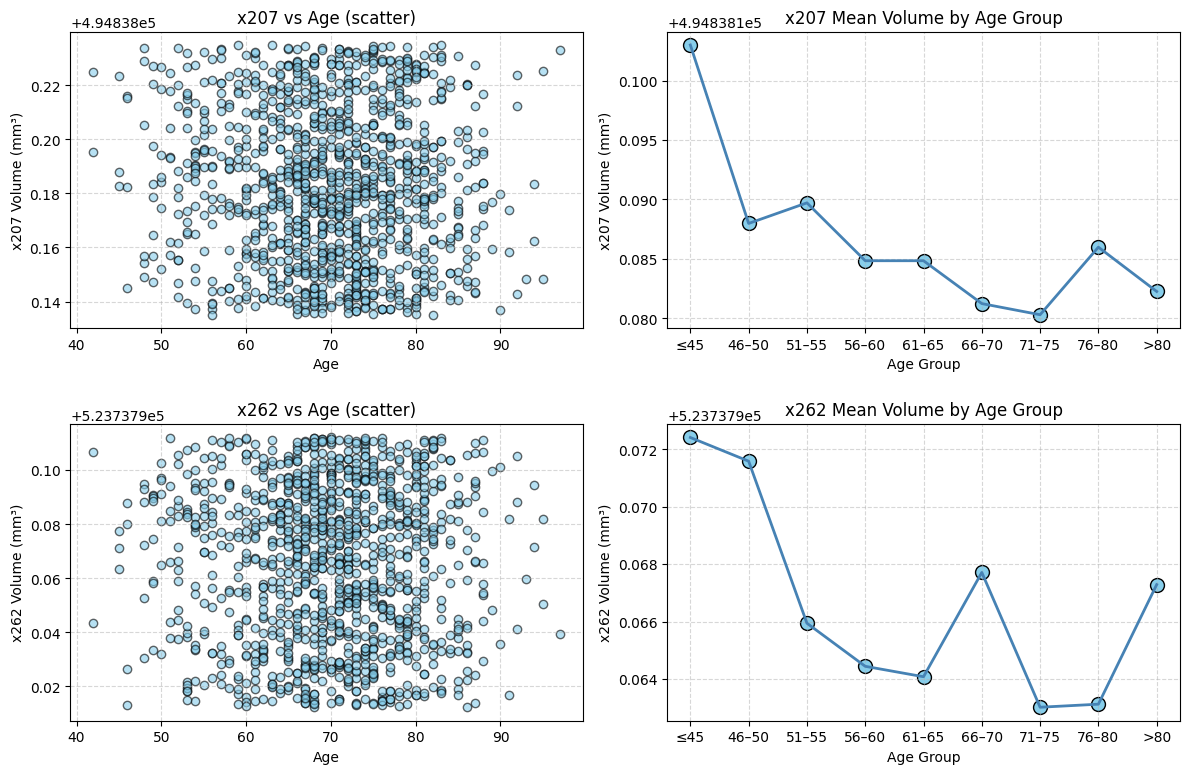

In [775]:
import matplotlib.pyplot as plt

y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

wm_min_mm3 = 451 * 1000  
wm_max_mm3 = 539 * 1000  

feature_means = X_imp_train.mean()

wm_like_features = feature_means[(feature_means >= wm_min_mm3) & (feature_means <= wm_max_mm3)]
print(f"Found {len(wm_like_features)} GM-like features:")
print(wm_like_features)

for feat in wm_like_features.index[:10]:
    print(feat,
          "min:", X_imp_train[feat].min(),
          "max:", X_imp_train[feat].max(),
          "mean:", X_imp_train[feat].mean())


top_features_wm = wm_like_features.index  

bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

top_features_wm = wm_like_features.index[:2]  

n_rows = len(top_features_wm)
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_wm):
    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.6, color='skyblue', edgecolor='k')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)

    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='skyblue', s=100, edgecolor='k')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='steelblue', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean Volume by Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## __CFS__

In [776]:
import matplotlib.pyplot as plt

y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

cfs_min_mm3 = 330 * 1000  
cfs_max_mm3 = 450 * 1000  

feature_means = X_imp_train.mean()

cfs_like_features = feature_means[(feature_means >= cfs_min_mm3) & (feature_means <= cfs_max_mm3)]
print(f"Found {len(cfs_like_features)} GM-like features:")
print(cfs_like_features)

for feat in cfs_like_features.index[:10]:
    print(feat,
          "min:", X_imp_train[feat].min(),
          "max:", X_imp_train[feat].max(),
          "mean:", X_imp_train[feat].mean())

top_features_cfs = cfs_like_features.index


# bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
# labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
# age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# # Select top features (or all)
# top_features_cfs = cfs_like_features.index[:2]  

# n_rows = len(top_features_cfs)
# fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows), sharey=False)

# for i, feat in enumerate(top_features_cfs):
#     # Left: scatter of individual values vs age
#     axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.6, color='skyblue', edgecolor='k')
#     axes[i, 0].set_title(f'{feat} vs Age (scatter)')
#     axes[i, 0].set_xlabel('Age')
#     axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 0].grid(True, linestyle='--', alpha=0.5)

#     grouped_means = X_imp_train[feat].groupby(age_groups).mean()
#     axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='skyblue', s=100, edgecolor='k')
#     axes[i, 1].plot(grouped_means.index, grouped_means.values, color='steelblue', linewidth=2)
#     axes[i, 1].set_title(f'{feat} Mean Volume by Age Group')
#     axes[i, 1].set_xlabel('Age Group')
#     axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 1].grid(True, linestyle='--', alpha=0.5)

# plt.tight_layout()
# plt.show()

Found 9 GM-like features:
x185    363704.311085
x295    388843.502354
x307    372663.102065
x492    357883.294165
x550    339510.185727
x666    349429.995173
x668    427393.987411
x675    409217.297284
x808    368045.117241
dtype: float64
x185 min: 363704.2616998 max: 363704.3616919 mean: 363704.3110847158
x295 min: 388843.45142709 max: 388843.55140818 mean: 388843.50235404755
x307 min: 372663.05125728 max: 372663.15118039 mean: 372663.10206496075
x492 min: 357883.24461822 max: 357883.3444171 mean: 357883.29416479764
x550 min: 339510.13537466 max: 339510.23503956 mean: 339510.1857265339
x666 min: 349429.94659632 max: 349430.04646383 mean: 349429.99517302326
x668 min: 253829.0760318 max: 630785.81756755 mean: 427393.9874109153
x675 min: 296575.62179915 max: 554544.83882351 mean: 409217.29728394403
x808 min: 368045.06904324 max: 368045.16894008 mean: 368045.1172406388


## __NEGATIVE CORRELATION__

In [777]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

if isinstance(y_train_df, pd.DataFrame):
    y_age = y_train_df.iloc[:, 0]
else:
    y_age = y_train_df

corr_with_age = X_imp_train.apply(lambda x: np.corrcoef(x, y_age)[0, 1])
corr_sorted = corr_with_age.sort_values()

top_features_negative = corr_sorted.index[:40]

# bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
# labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
# age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# n_rows = len(top_features_negative[:2])
# fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows), sharey=False)

# for i, feat in enumerate(top_features_negative[:1]):
#     feat_mean = X_imp_train[feat].mean()  # compute mean
#     feat_corr = corr_with_age[feat]
    
#     axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.5, color='skyblue', edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³| r={feat_corr:.3f}')
#     axes[i, 0].set_title(f'{feat} vs Age (scatter)')
#     axes[i, 0].set_xlabel('Age')
#     axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 0].grid(True, linestyle='--', alpha=0.5)
#     axes[i, 0].legend()
    
#     grouped_means = X_imp_train[feat].groupby(age_groups).mean()
#     axes[i, 1].scatter(y_age, X_imp_train[feat], alpha=0.3, color='lightblue', edgecolor='k', label='Individual')
#     axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='red', s=80, edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
#     axes[i, 1].plot(grouped_means.index, grouped_means.values, color='darkred', linewidth=2)
#     axes[i, 1].set_title(f'{feat} Mean per Age Group')
#     axes[i, 1].set_xlabel('Age Group')
#     axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 1].grid(True, linestyle='--', alpha=0.5)
#     axes[i, 1].legend()

# plt.tight_layout()
# plt.show()


## __POSITIVE CORRELATIONS__

In [778]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(y_train_df, pd.DataFrame):
    y_age = y_train_df.iloc[:, 0]
else:
    y_age = y_train_df

corr_with_age = X_imp_train.apply(lambda x: np.corrcoef(x, y_age)[0, 1])
corr_sorted = corr_with_age.sort_values(ascending=False)

top_features_positive = corr_sorted.index[:40]

# Define age bins
# bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
# labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
# age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# n_rows = len(top_features_positive[:2])
# fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows), sharey=False)

# for i, feat in enumerate(top_features_positive[:1]):
#     feat_mean = X_imp_train[feat].mean()  # compute mean
#     feat_corr = corr_with_age[feat]
    
#     axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.5, color='skyblue', edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
#     axes[i, 0].set_title(f'{feat} vs Age (scatter)')
#     axes[i, 0].set_xlabel('Age')
#     axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 0].grid(True, linestyle='--', alpha=0.5)
#     axes[i, 0].legend()
    
#     grouped_means = X_imp_train[feat].groupby(age_groups).mean()
#     axes[i, 1].scatter(y_age, X_imp_train[feat], alpha=0.3, color='lightblue', edgecolor='k', label='Individual')
#     axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='red', s=80, edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
#     axes[i, 1].plot(grouped_means.index, grouped_means.values, color='darkred', linewidth=2)
#     axes[i, 1].set_title(f'{feat} Mean per Age Group')
#     axes[i, 1].set_xlabel('Age Group')
#     axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 1].grid(True, linestyle='--', alpha=0.5)
#     axes[i, 1].legend()

# plt.tight_layout()
# plt.show()


## __NON-LINEAR CORR__

✅ Added 70 squared features to each dataset.
New train shape: (1157, 898)
Top linear features by F-score:
Index(['x133', 'x133_squared', 'x334_squared', 'x334', 'x194_squared', 'x194',
       'x485_squared', 'x485', 'x465_squared', 'x465', 'x458', 'x159', 'x415',
       'x702', 'x507', 'x654', 'x654_squared', 'x287_squared', 'x287',
       'x200_squared', 'x200', 'x115', 'x712', 'x712_squared', 'x362_squared',
       'x362', 'x458_squared', 'x410', 'x306_squared', 'x531', 'x410_squared',
       'x306', 'x327', 'x748_squared', 'x349_squared', 'x748', 'x349', 'x242',
       'x203', 'x327_squared', 'x242_squared', 'x286', 'x254', 'x320',
       'x320_squared', 'x172', 'x172_squared', 'x203_squared', 'x146_squared',
       'x452', 'x320_cube', 'x23_squared', 'x310', 'x310_squared', 'x23',
       'x766', 'x766_squared', 'x146', 'x531_squared', 'x612', 'x254_squared',
       'x612_squared', 'x325', 'x612_cube', 'x325_squared', 'x640_cube',
       'x640_squared', 'x309', 'x745_squared', 'x745

/tmp/ipykernel_23436/1890065483.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_imp_train[f"{feat}_cube"] = X_imp_train[feat] ** 3
/tmp/ipykernel_23436/1890065483.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_imp_test[f"{feat}_cube"] = X_imp_test[feat] ** 3
/tmp/ipykernel_23436/1890065483.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

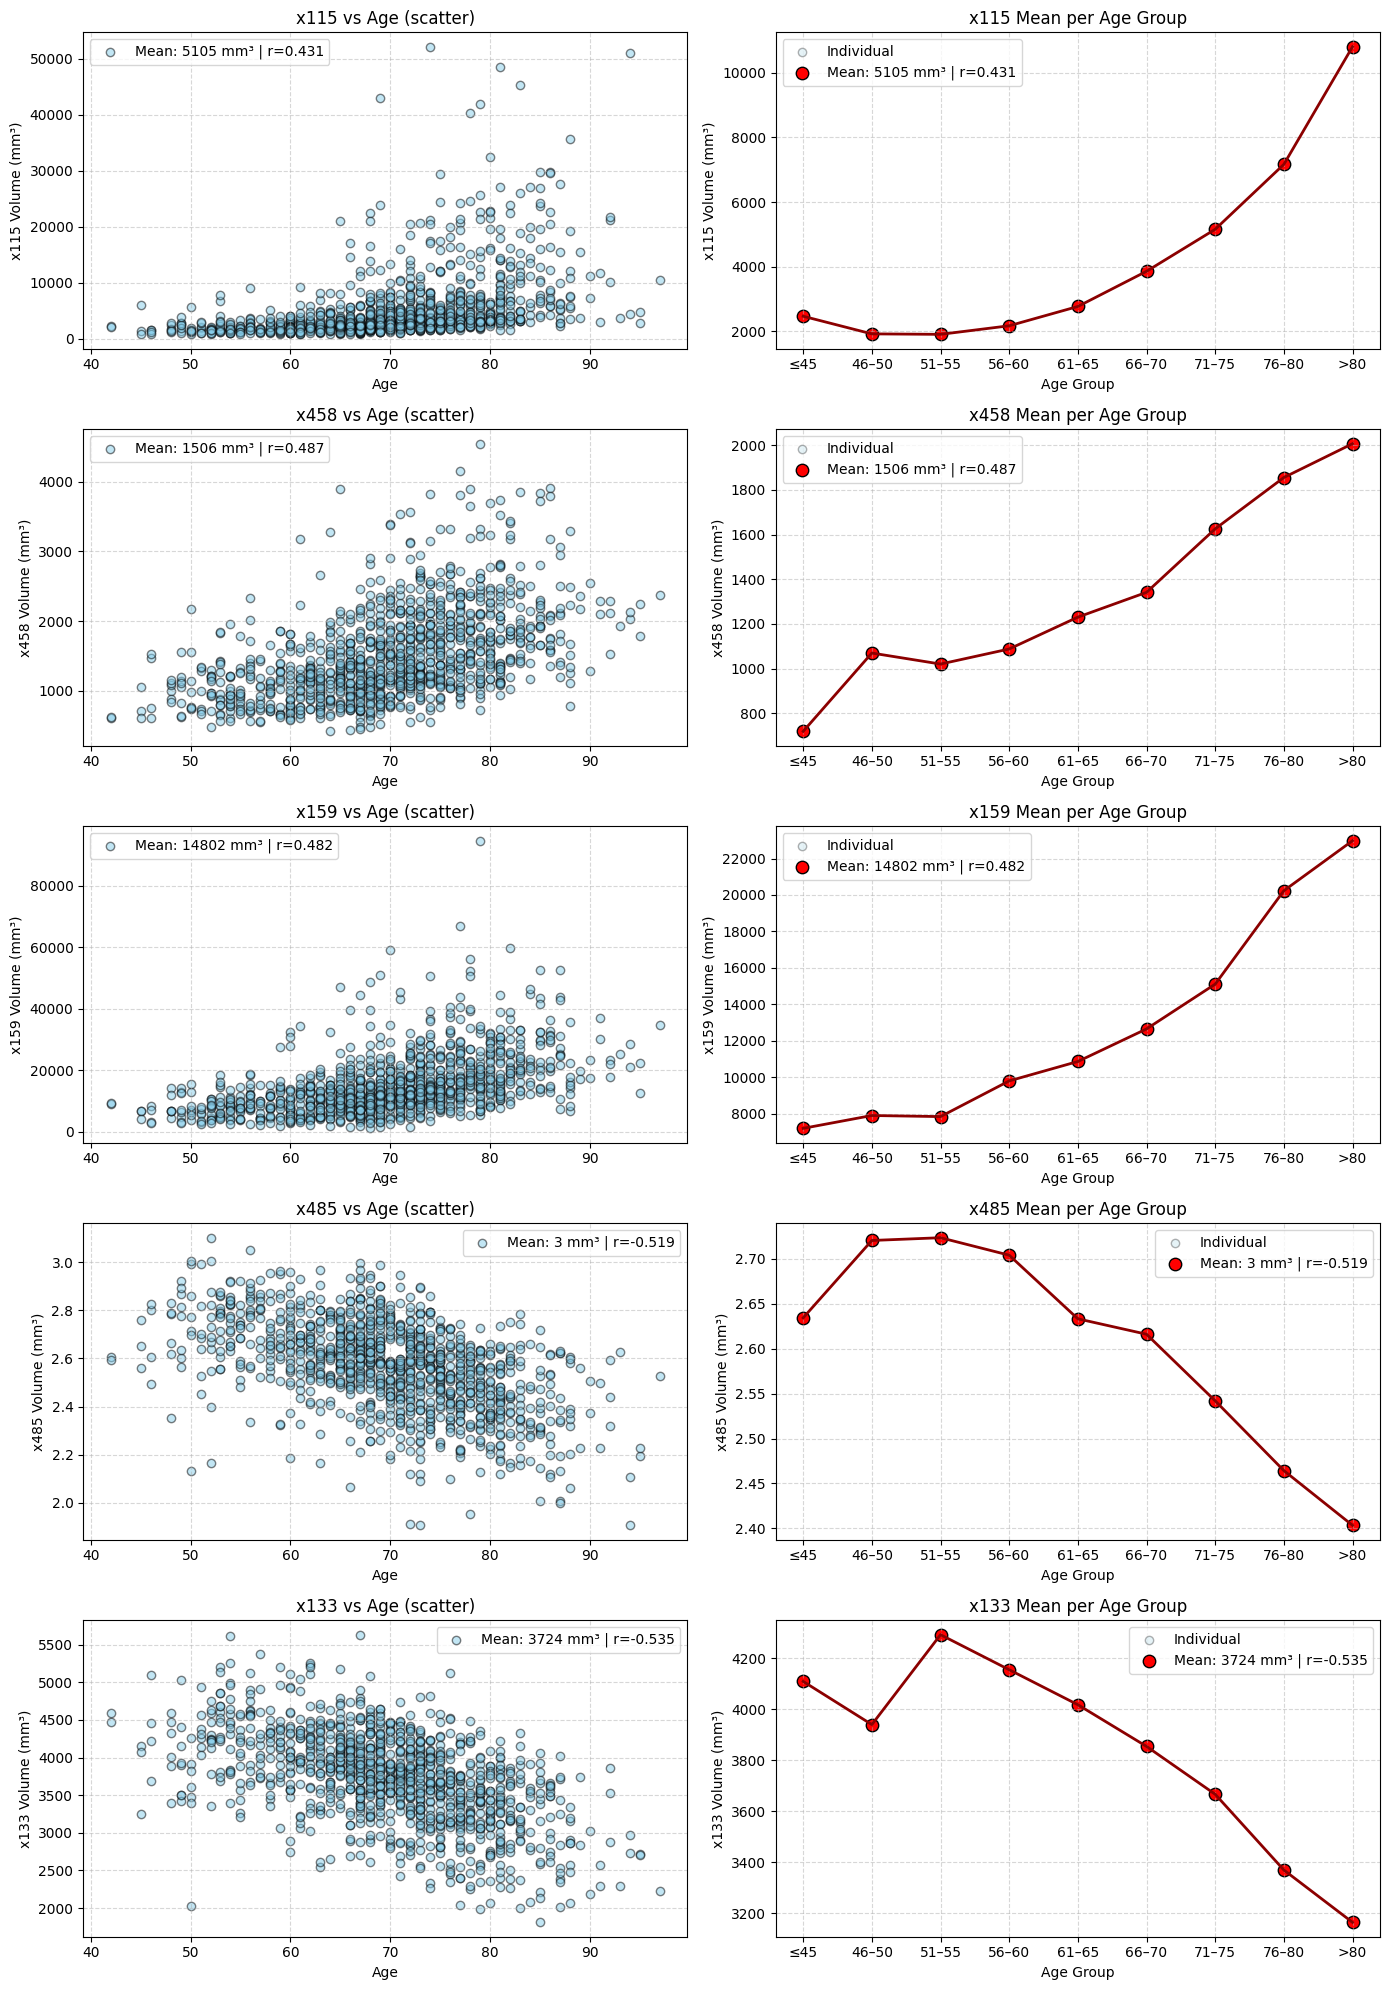

In [779]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression, f_regression
from itertools import combinations


y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

mi_scores = mutual_info_regression(X_imp_train, y_age, random_state=42)
mi_scores_series = pd.Series(mi_scores, index=X_imp_train.columns)
mi_sorted = mi_scores_series.sort_values(ascending=False)

top_features_mi = mi_sorted.index[:100]

top_features_30 = mi_sorted.index[:70]

top_features_60 = mi_sorted.index[50:80]

for feat in top_features_30:
    X_imp_train[f"{feat}_squared"] = X_imp_train[feat] ** 2
    if 'X_imp_test' in locals():
        X_imp_test[f"{feat}_squared"] = X_imp_test[feat] ** 2

print(f"✅ Added {len(top_features_30)} squared features to each dataset.")
print(f"New train shape: {X_imp_train.shape}")

# # ADD cube
for feat in top_features_60:
    X_imp_train[f"{feat}_cube"] = X_imp_train[feat] ** 3
    if 'X_imp_test' in locals():
        X_imp_test[f"{feat}_cube"] = X_imp_test[feat] ** 3

# top_20_features = top_features_mi[:10]

# for f1, f2 in combinations(top_20_features, 2):
#     X_imp_train[f"{f1}_x_{f2}"] = X_imp_train[f1] * X_imp_train[f2]
#     if 'X_imp_test' in locals():
#         X_imp_test[f"{f1}_x_{f2}"] = X_imp_test[f1] * X_imp_test[f2]



f_scores, p_values = f_regression(X_imp_train, y_age)

f_scores_series = pd.Series(f_scores, index=X_imp_train.columns)
f_sorted = f_scores_series.sort_values(ascending=False)

# Select top k linear features (e.g., top 50)
top_features_linear = f_sorted.index[:90]

print("Top linear features by F-score:")
print(top_features_linear)


print(f"✅ Added {len(top_features_30)} squared features to each dataset.")
print(f"New train shape: {X_imp_train.shape}")

corr_with_age = X_imp_train[top_features_mi].apply(lambda x: np.corrcoef(x, y_age)[0,1])

bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)


top_features_plot = top_features_mi[:5]
n_rows = len(top_features_plot)
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_plot):
    feat_mean = X_imp_train[feat].mean()
    feat_corr = corr_with_age[feat]

    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.5, color='skyblue', edgecolor='k',
                       label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)
    axes[i, 0].legend()

    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(y_age, X_imp_train[feat], alpha=0.3, color='lightblue', edgecolor='k', label='Individual')
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='red', s=80, edgecolor='k',
                       label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='darkred', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean per Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

## __CREATE DATAFRAME__

In [780]:
# NOTE: only ones that have correlation
# Filter only existing features
existing_cfs = [f for f in ['x675', 'x668'] if f in top_features_cfs]
existing_gm = [f for f in ['x414'] if f in top_features_gm]
merged_features = pd.Index(existing_gm + existing_cfs)
print(merged_features)

squared_features = [f"{feat}_squared" for feat in top_features_30 if f"{feat}_squared" in X_imp_train.columns]
cube_features = [f"{feat}_cube" for feat in top_features_60 if f"{feat}_cube" in X_imp_train.columns]

all_selected_features = list(
    pd.Index(top_features_positive)
    .union(top_features_negative)
    .union(merged_features)
    .union(top_features_mi) 
    .union(top_features_linear)
    .union(squared_features)
    .union(cube_features)   
)

print(f"Total selected features: {len(all_selected_features)}")
print(all_selected_features[:20])  # preview first 20

# --- Select these features from X_imp_train and X_imp_test ---
X_train_final = X_imp_train[all_selected_features].copy()
X_test_final = X_imp_test[all_selected_features].copy()

# Ensure numeric dtype
X_train_final = X_train_final.astype(float)
X_test_final = X_test_final.astype(float)

print(X_train_final.shape)
print(X_test_final.shape)
print(X_train_final.head())

Index(['x675', 'x668'], dtype='object')
Total selected features: 226
['x113', 'x113_cube', 'x113_squared', 'x115', 'x115_squared', 'x132', 'x133', 'x133_squared', 'x143', 'x146', 'x146_squared', 'x151', 'x159', 'x159_squared', 'x172', 'x172_squared', 'x174', 'x194', 'x194_squared', 'x200']
(1157, 226)
(776, 226)
           x113     x113_cube  x113_squared          x115  x115_squared  \
0  14114.997688  2.812176e+12  1.992332e+08  12802.203605  1.638964e+08   
1  16292.423778  4.324711e+12  2.654431e+08   1921.015297  3.690300e+06   
2  11899.476849  1.684937e+12  1.415975e+08   2167.802432  4.699367e+06   
4  13843.961128  2.653268e+12  1.916553e+08   6424.918043  4.127957e+07   
5  13443.587366  2.429660e+12  1.807300e+08    786.410440  6.184414e+05   

           x132         x133  x133_squared       x143      x146  ...  \
0 -1.324918e+06  3562.654007  1.269250e+07  11.520820  2.466789  ...   
1 -1.875708e+06  4373.986953  1.913176e+07   6.702850  2.467671  ...   
2 -1.191686e+06  35

In [781]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_final, y_train_df, test_size=0.15, random_state=42)

print(f"shape of X_train is : {X_train.shape}")
print(f"shape of y_train is : {y_train.shape}")
print(f"shape of X_val is : {X_val.shape}")
print(f"shape of y_val : {y_val.shape}")

X_train.head()

shape of X_train is : (983, 226)
shape of y_train is : (983, 1)
shape of X_val is : (174, 226)
shape of y_val : (174, 1)


,x113,x113_cube,x113_squared,x115,x115_squared,x132,x133,x133_squared,x143,x146,...,x79_cube,x79_squared,x817,x817_squared,x819,x83,x87,x87_cube,x87_squared,x92
146,14048.290633,2.772493e+12,1.973545e+08,2753.238669,7.580323e+06,-1.302912e+06,3570.737320,1.275017e+07,7.709559,2.328535,...,-8.683306e+14,9.101718e+09,2.363702,5.587088,8.748283e+05,1006.218224,9244.009963,7.899166e+11,8.545172e+07,2.679603
968,13978.519947,2.731389e+12,1.953990e+08,6020.151127,3.624222e+07,-1.351160e+06,4175.249348,1.743271e+07,20.055845,2.338089,...,-9.111921e+14,9.398819e+09,2.382944,5.678421,8.748733e+05,1013.912014,8442.092100,6.016588e+11,7.126892e+07,2.538433
1057,11197.548040,1.404005e+12,1.253851e+08,4396.325483,1.932768e+07,-1.344789e+06,3178.866905,1.010519e+07,47.969097,2.365183,...,-8.824772e+14,9.200307e+09,2.588318,6.699388,9.295004e+05,1089.750591,10242.093519,1.074401e+12,1.049005e+08,2.471104
386,12645.716197,2.022229e+12,1.599141e+08,3348.285370,1.121101e+07,-1.272163e+06,3826.644079,1.464320e+07,12.997224,2.468082,...,-9.173740e+14,9.441281e+09,2.814080,7.919043,9.120688e+05,1009.723675,8654.058873,6.481261e+11,7.489273e+07,2.692559
144,14252.642166,2.895250e+12,2.031378e+08,2521.692305,6.358932e+06,-1.488320e+06,3997.577689,1.598063e+07,0.000000,2.491093,...,-1.133395e+15,1.087062e+10,2.465508,6.078731,1.016887e+06,1030.440132,12239.009341,1.833322e+12,1.497933e+08,3.352342


## __STACKING BOOSTING__

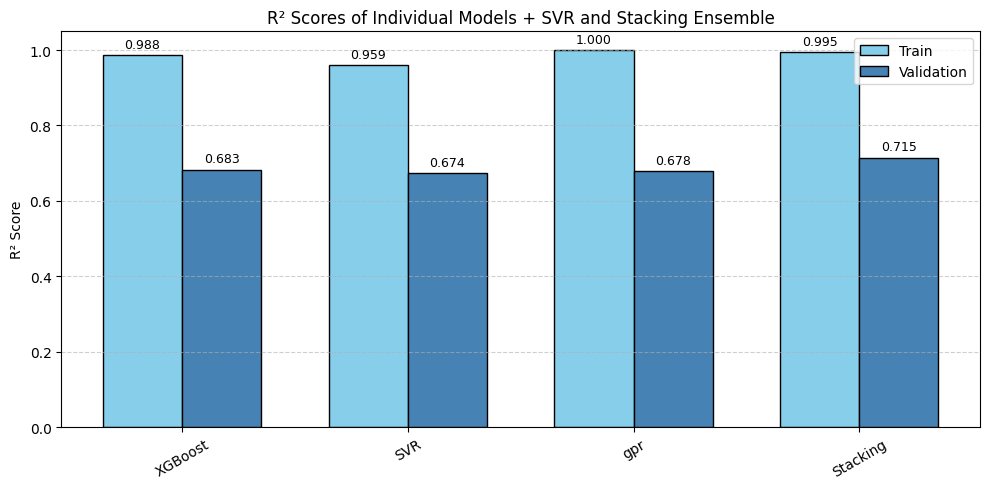

In [782]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import Lars, LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import ElasticNetCV


y_train = np.ravel(y_train)
y_val = np.ravel(y_val)


xgb = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.68,
    colsample_bytree=0.7,
    reg_alpha=0.7,
    reg_lambda=2.0,
    random_state=42,
    objective='reg:squarederror',
    verbosity=0
)


svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=24, epsilon=0.05))
])


gpr = Pipeline([
    ('scaler', StandardScaler()),                     
    ('gpr', GaussianProcessRegressor(
        kernel=0.7 * RBF(length_scale=1.5, length_scale_bounds=(0.1, 10.0)),
        n_restarts_optimizer=2,
        alpha=1e-2,                                          
        normalize_y=True,                          
        random_state=42
    ))
])

estimators = [
    ('xgb', xgb),
    ('svr', svr),
    ('gpr', gpr),
]

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=BayesianRidge(),
    passthrough=False,
    n_jobs=-1
)

models = [
    ('XGBoost', xgb),
    ('SVR', svr),
    ('gpr', gpr),
    ('Stacking', stack_model),
]

r2_train_list = []
r2_val_list = []
predictions_val = {}

for name, model in models:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    r2_train_list.append(r2_score(y_train, y_pred_train))
    r2_val_list.append(r2_score(y_val, y_pred_val))

    predictions_val[name] = y_pred_val

x = np.arange(len(models))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, r2_train_list, width, label='Train', color='skyblue', edgecolor='k')
rects2 = ax.bar(x + width/2, r2_val_list, width, label='Validation', color='steelblue', edgecolor='k')

ax.set_ylabel('R² Score')
ax.set_xticks(x)
ax.set_xticklabels([name for name, _ in models], rotation=30)
ax.set_title('R² Scores of Individual Models + SVR and Stacking Ensemble')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

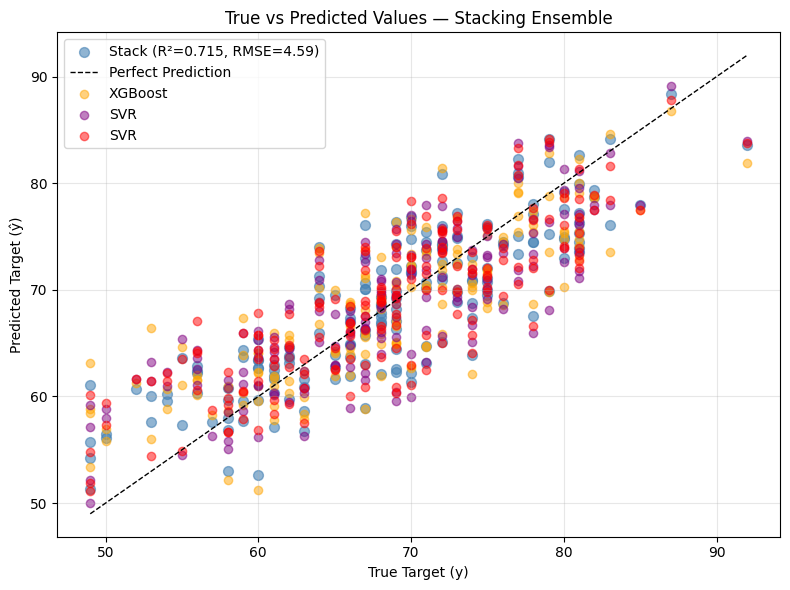

In [783]:
import matplotlib.pyplot as plt
import numpy as np

y_pred_stack = stack_model.predict(X_val)

r2 = r2_score(y_val, y_pred_stack)
rmse = mean_squared_error(y_val, y_pred_stack) ** 0.5

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_stack, color='steelblue', alpha=0.6, s=50, label=f'Stack (R²={r2:.3f}, RMSE={rmse:.2f})')

min_val = min(y_val.min(), y_pred_stack.min())
max_val = max(y_val.max(), y_pred_stack.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1, label='Perfect Prediction')

plt.scatter(y_val, predictions_val['XGBoost'], color='orange', alpha=0.5, label='XGBoost')
plt.scatter(y_val, predictions_val['SVR'], color='purple', alpha=0.5, label='SVR')
plt.scatter(y_val, predictions_val['gpr'], color='red', alpha=0.5, label='SVR')
# plt.scatter(y_val, predictions_val['enet'], color='red', alpha=0.5, label='enet')


plt.xlabel('True Target (y)')
plt.ylabel('Predicted Target (ŷ)')
plt.title('True vs Predicted Values — Stacking Ensemble')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


VAL before RMSE: 4.592976224190926
VAL after  RMSE: 4.547955373047681
VAL before R2: 0.7146484484577232
VAL after  R2: 0.7202151252208153


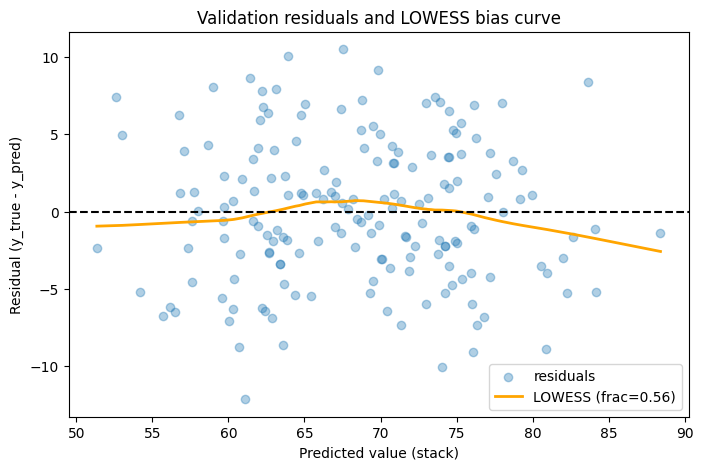

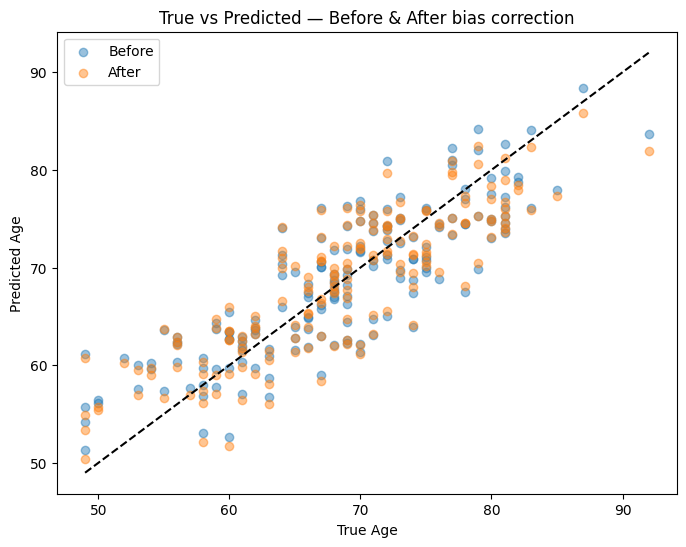

In [794]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

y_pred_val = y_pred_stack            
residuals = y_val - y_pred_val

lowess = sm.nonparametric.lowess
frac = 0.56
lowess_fit = lowess(residuals, y_pred_val, frac=frac, return_sorted=True) 

from scipy.interpolate import interp1d
xs = lowess_fit[:, 0]
ys = lowess_fit[:, 1]
bias_func = interp1d(xs, ys, bounds_error=False, fill_value=(ys[0], ys[-1]))

bias_corr_val = bias_func(y_pred_val)
y_pred_val_corrected = y_pred_val + bias_corr_val

print("VAL before RMSE:", mean_squared_error(y_val, y_pred_val) ** 0.5) 
print("VAL after  RMSE:", mean_squared_error(y_val, y_pred_val_corrected) ** 0.5) 
print("VAL before R2:", r2_score(y_val, y_pred_val))
print("VAL after  R2:", r2_score(y_val, y_pred_val_corrected))

plt.figure(figsize=(8,5))
plt.scatter(y_pred_val, residuals, alpha=0.35, label='residuals')
plt.plot(xs, ys, linewidth=2, label=f'LOWESS (frac={frac})', color='orange')
plt.axhline(0, linestyle='--', color='k')
plt.xlabel('Predicted value (stack)')
plt.ylabel('Residual (y_true - y_pred)')
plt.title('Validation residuals and LOWESS bias curve')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.45, label='Before')
plt.scatter(y_val, y_pred_val_corrected, alpha=0.45, label='After')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
plt.legend()
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('True vs Predicted — Before & After bias correction')
plt.show()

In [795]:
X_new_df = pd.read_csv("X_test.csv")  
ids = X_new_df['id'].to_numpy()

y_pred_test = stack_model.predict(X_test_final)

# bias_correction_test = bias_model.predict(y_pred_test.reshape(-1, 1))
# y_pred_test_corrected = y_pred_test + bias_correction_test

bias_corr_test = bias_func(y_pred_test)
y_pred_test_corrected = y_pred_test + bias_corr_test


submission_df = pd.DataFrame({
    'id': ids,
    'y': y_pred_test_corrected
})

submission_df.to_csv("submission97.csv", index=False)
print("Submission file saved as submission75.csv")

Submission file saved as submission75.csv


## __TEST MODEL ON UNSEEN DATA AND CREATE SUBMISSION FILE__

In [796]:
import csv

file1 = "submission96.csv"
file2 = "submission97.csv"

with open(file1) as f1, open(file2) as f2:
    reader1 = csv.reader(f1)
    reader2 = csv.reader(f2)
    
    header1 = next(reader1)
    header2 = next(reader2)
    
    print(f"{header1[0]:<5} {header1[1]:<20}  {'Difference':<20}")
    
    for row1, row2 in zip(reader1, reader2):
        id1, y1 = row1
        id2, y2 = row2
        y1 = float(y1)
        y2 = float(y2)
        diff = abs(y1 - y2)
        print(f"{id1:<5} {y1:<20} {diff:<20}")


id    y                     Difference          
0.0   57.992842600375845   0.004391730426689833
1.0   75.73448817025891    0.12876013448574497 
2.0   69.97882224029625    0.013716346621421849
3.0   76.4658978200416     0.102697553893762   
4.0   72.13980148715416    0.05402052033555549 
5.0   54.0311543760784     0.0003610830184825886
6.0   66.38078562179291    0.06716776027593596 
7.0   73.83689128765481    0.048992309004432855
8.0   70.0595413977822     0.03194578972704676 
9.0   59.591423532099384   0.050865189549448075
10.0  76.52923751033211    0.0671191517921983  
11.0  78.2404673844442     0.00990244768905768 
12.0  56.95847773129343    0.1575137414200114  
13.0  71.97277234434792    0.06237744400186784 
14.0  75.5265585189804     0.12363768869337832 
15.0  67.03420384928278    0.16821905107244106 
16.0  76.03796452225461    0.12017695091807923 
17.0  72.63959584402589    0.020735268543617735
18.0  66.76010993565244    0.07240784544026724 
19.0  69.29100572881114    0.081615490